## Processing initial h5 files

In [48]:
# Importing relevant packages. Sparticles_FCC_notnorm has an edited dataset.py within it.
#Dataset from sparticles_FCC has no normalisation and only has the low level features in USEFUL_COLS

from sparticles import EventsDataset

from sparticles import DEFAULT_EVENT_SUBSETS

import matplotlib.pyplot as plt

from sparticles.transforms import MakeHomogeneous
make_homogeneous_trans = MakeHomogeneous()

from sparticles import plot_event_2d

import os

import errno

import numpy as np

from numpy import pi

In [95]:


#Code block for processing the raw data from the h5 file. These are the h5 files that cut events with pT < 20GeV.
sig_no = 21800
sgt_no = 21800
ttb_no = 0
sig_last = sig_no - 1
sgt_last = (sgt_no + sig_no) - 1



dataset = EventsDataset(
    root='data',
    url='https://cernbox.cern.ch/s/8Oh5dfiB9K3qHnl/download',
    delete_raw_archive=False,
    add_edge_index=True,
    event_subsets={'signal': sig_no, 'singletop': sgt_no, 'ttbar': ttb_no}, #For the FCC, only ttbar events are used, but the h5 file for background is saved and taken from the 'singletop' file. 
#    transform=MakeHomogeneous(),
    download_type=2,
    signal_filename='FCChh_lephad.h5'  # Specify the signal filename here
)

In [77]:
print(dataset)

EventsDataset(43600)


## Relevant Classes

In [50]:
#Defining the object numbers in each event.

tau = 0
l1 = 1
b1 = 2
b2 = 3
energy = 4
jet = 5

pT = 0
eta = 1
phi = 2

#function for creating lists of specific features of specific objects, split into signal. single-top and tt-bar.
#This can be done this way because all the signal events are processed first, then single top then tt-bar.
def obj_ft(obj,ft):

    sig_obj_ft = []
    sgt_obj_ft = []
    ttb_obj_ft = []

    for i in range(len(dataset)):

        if dataset[i].x.shape == (5,3) and obj == 5: #makes it so that final object (jet) is skipped for graphs without an extra jet.
            continue
        
        elif dataset[i].y.item() == 1: #and dataset[i].x.shape == (6,3):  
            sig_obj_ft.append(dataset[i].x[obj,ft].item())

        elif dataset[i].y.item() == 0 and  i > sig_last and i < (sgt_last + 1):# and dataset[i].x.shape == (6,3):
            sgt_obj_ft.append(dataset[i].x[obj,ft].item())

        elif dataset[i].y.item() == 0 and  i > sgt_last:# and dataset[i].x.shape == (6,3):
            ttb_obj_ft.append(dataset[i].x[obj,ft].item())
    
    return sig_obj_ft, sgt_obj_ft, ttb_obj_ft,

#notation here suggests singletop data is being used but for the FCC the background is ttbar data.

In [51]:
#class with functions for calculating complex features other than centrality MET.
class Higher_order:
    def __init__(self, pt1, pt2, eta1, eta2, phi1, phi2):
        self.pt1 = pt1
        self.pt2 = pt2
        self.eta1 = eta1
        self.eta2 = eta2
        self.phi1 = phi1
        self.phi2 = phi2

    def dEta(self):
        delta_eta = abs(self.eta1 - self.eta2)
        return delta_eta

    # def dPhi(self):
    #     delta_phi = abs(self.phi1 - self.phi2)
    #     return delta_phi

    def dPhi(self):
        delta_phi = self.phi1 - self.phi2
        #print(dphi, dphi < -pi)
    
        while delta_phi >= pi: delta_phi -= 2*pi;
        while delta_phi < -pi: delta_phi += 2*pi;
    
        return delta_phi
    
    def dR(self):
        delta_R = np.sqrt((self.dEta())**2 + (self.dPhi())**2)
        return delta_R

    def inv_M(self):
        M = np.sqrt(2*(self.pt1)*(self.pt2)*(np.cosh(self.dEta())-np.cos(self.dPhi())))
        return M

#x is only for lepton, tau and l1 but we include it here without those specified to make life easier.
    # def x(def x(phi_met, phi_l1, phi_l2):
    #     x = np.sin(phi_met - phi_l1) / np.sin(phi_l2 - phi_l1)
    #     return x
    def dpT(self):
        delta_pT = self.pt2 - self.pt1
        return delta_pT

    def m_T(self):
        transverse_mass = np.sqrt(2*self.pt1*(self.pt2)*(1 - np.cos(self.dPhi())))
        return transverse_mass

In [52]:
# function for calculating complex features between two objects for each event for signal and background.
def obj_cpxft(obj1,obj2):

    sig_dEta_objects = []
    sig_dPhi_objects = []
    sig_dR_objects = []
    sig_invM_objects = []
    sig_dpT_objects = []
    sig_mTW_objects = []

    bkg_dEta_objects = []
    bkg_dPhi_objects = []
    bkg_dR_objects = []
    bkg_invM_objects = []
    bkg_dpT_objects = []
    bkg_mTW_objects = []
    
    for i in range (len(dataset)):

        if i < sig_no:

            pt1 = dataset[i].x[obj1,pT].item()
            pt2 = dataset[i].x[obj2,pT].item()
            eta1 = dataset[i].x[obj1,eta].item()
            eta2 = dataset[i].x[obj2,eta].item()
            phi1 = dataset[i].x[obj1,phi].item()
            phi2 = dataset[i].x[obj2,phi].item()
        
            higher_order = Higher_order(pt1,pt2,eta1,eta2,phi1,phi2)

            sig_dEta_objects.append(higher_order.dEta())
            sig_dPhi_objects.append(higher_order.dPhi())
            sig_dR_objects.append(higher_order.dR())
            sig_invM_objects.append(higher_order.inv_M())
            sig_dpT_objects.append(higher_order.dpT())
            sig_mTW_objects.append(higher_order.m_T())

        elif i > (sig_no-1)  and i < (sgt_last + 1):

            pt1 = dataset[i].x[obj1,pT].item()
            pt2 = dataset[i].x[obj2,pT].item()
            eta1 = dataset[i].x[obj1,eta].item()
            eta2 = dataset[i].x[obj2,eta].item()
            phi1 = dataset[i].x[obj1,phi].item()
            phi2 = dataset[i].x[obj2,phi].item()
        
            higher_order = Higher_order(pt1,pt2,eta1,eta2,phi1,phi2)

            bkg_dEta_objects.append(higher_order.dEta())
            bkg_dPhi_objects.append(higher_order.dPhi())
            bkg_dR_objects.append(higher_order.dR())
            bkg_invM_objects.append(higher_order.inv_M())
            bkg_dpT_objects.append(higher_order.dpT())
            bkg_mTW_objects.append(higher_order.m_T())
                        
    return sig_dEta_objects, sig_dPhi_objects, sig_dR_objects, sig_invM_objects, sig_dpT_objects, sig_mTW_objects, bkg_dEta_objects, bkg_dPhi_objects, bkg_dR_objects, bkg_invM_objects, bkg_dpT_objects, bkg_mTW_objects

### Checking distributions

length of signal invariant masses: 21800
First signal value for invariant mass 118.67097173812994

length of background invariant masses: 21800
First background value for invariant mass 86.86465171461133



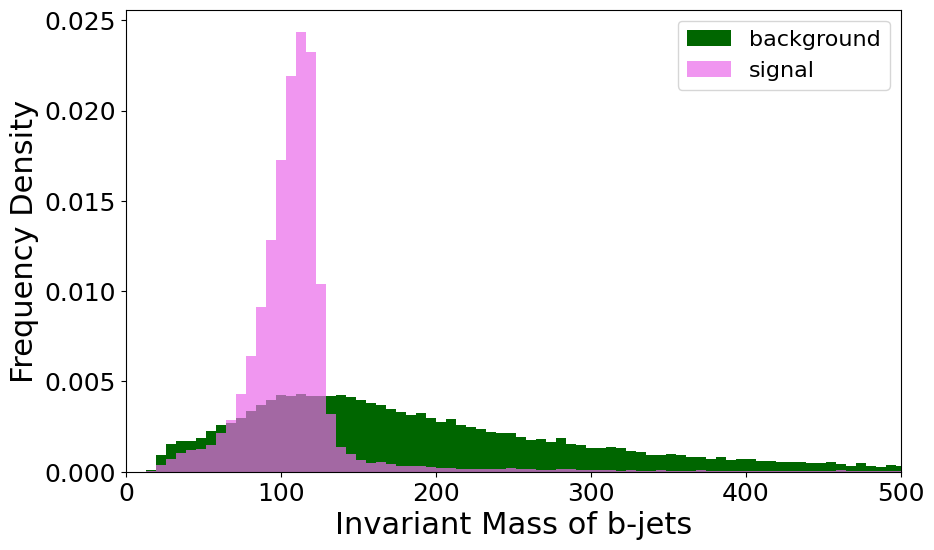

In [53]:
#Applying function to the two b-jets and plotting.
sig_dEta_bb, sig_dPhi_bb, sig_dR_bb, sig_invM_bb, sig_dpT_bb, sig_mTW_bb, bkg_dEta_bb, bkg_dPhi_bb, bkg_dR_bb, bkg_invM_bb, bkg_dpT_bb, bkg_mTW_bb = obj_cpxft(b1,b2)

#invM_bb = []

#invM_bb.append(higher_order_bb.inv_M())
import matplotlib.pyplot as plt


print('length of signal invariant masses:',len(sig_invM_bb))
print('First signal value for invariant mass',sig_invM_bb[0])
print('')
print('length of background invariant masses:',len(bkg_invM_bb))
print('First background value for invariant mass',bkg_invM_bb[0])
print('')

#Now we can plot all the values we need baso:

LEGEND_SIZE = 16
SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.figure(figsize=(10, 6))

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=LEGEND_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)

#a=ttb_tau_pt #a uniform distribution
b=bkg_invM_bb #a normal distribution
c=sig_invM_bb

bins=np.histogram(np.hstack((b,c)), bins=(50*15))[1] #get the bin edges
#plt.hist(a, bins,color='#93f393',alpha = 1,label= r'$t \bar{t}$',density = True)
plt.hist(b, bins,color='#006600',alpha = 1,label='background',density = True)
plt.hist(c, bins,color='#ea6aea',alpha = 0.7,label='signal',density = True)
#plt.title('Distribution of invariant mass of b-jets')
plt.xlim(0, 500)
plt.xlabel('Invariant Mass of b-jets')
plt.ylabel('Frequency Density')
plt.legend()
plt.savefig('FCC Inv mass b-jets')
plt.show()

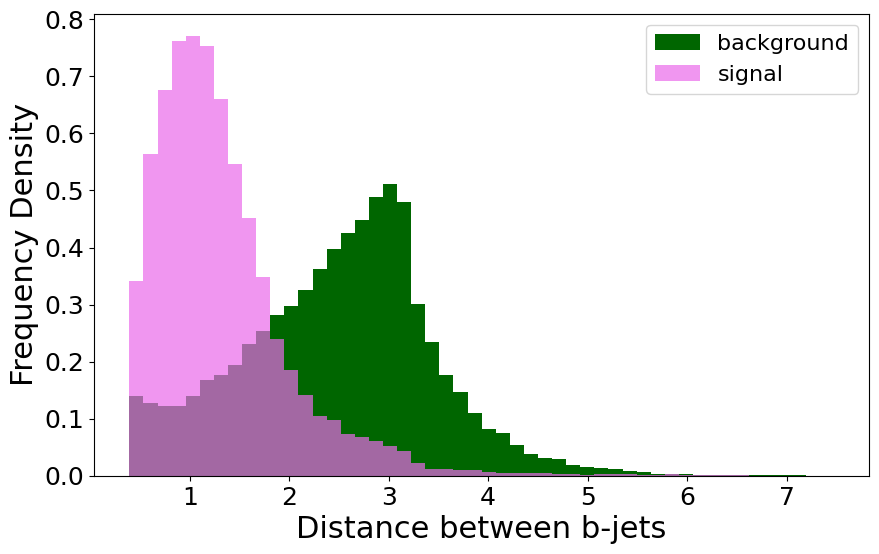

In [54]:
LEGEND_SIZE = 16
SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.figure(figsize=(10, 6))

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=LEGEND_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)

#a=ttb_tau_pt #a uniform distribution
b=bkg_dR_bb #a normal distribution
c=sig_dR_bb

bins=np.histogram(np.hstack((b,c)), bins=50)[1] #get the bin edges
#plt.hist(a, bins,color='#93f393',alpha = 1,label= r'$t \bar{t}$',density = True)
plt.hist(b, bins,color='#006600',alpha = 1,label='background',density = True)
plt.hist(c, bins,color='#ea6aea',alpha = 0.7,label='signal',density = True)
#plt.title('Distribution of invariant mass of b-jets')
plt.xlabel('Distance between b-jets')
plt.ylabel('Frequency Density')
plt.legend()
plt.savefig('FCC dR b-jets')
plt.show()

## Preparing dataframe

In [55]:
import pandas as pd
import numpy as np

sig_no = 21800
FCChh_tt012j = 21800
ttb_no = 0

df1 = pd.read_hdf('data/raw/signal/FCChh_lephad.h5') #importing the data
df2 = pd.read_hdf('data/raw/singletop/FCChh_lephad.h5')
#df1
#df2
df1 = df1.iloc[:sig_no] #cutting h5 file dataframe to match number of events used.
df2 = df2.iloc[:FCChh_tt012j]

In [56]:
#Adding column at front of rows so dataset.py doesn't remove object with 'nan' at the start.
start_zeros = np.zeros((sig_no,), dtype=int)

# print(start_zeros[0])
# print(start_zeros[1])
# print(len(start_zeros))

d0 = {'start': start_zeros,} 
df0_new_ft = pd.DataFrame(data=d0)

dict_df0_new_ft = df0_new_ft.to_dict('records')

df1.insert(17, "start", dict_df0_new_ft, True) #adding new column to dataframe so that m_bb values now attached.
df2.insert(17, "start", dict_df0_new_ft, True) #the same for background dataframe.

In [57]:
print('length of signal m_bb:',len(sig_invM_bb))
print('First signal value for m_bb',sig_invM_bb[0])
print('')
print('length of background m_bb:',len(bkg_invM_bb))
print('First background value for m_bb',bkg_invM_bb[0])
print('')

d1 = {'m_bb': sig_invM_bb,} #df1 corresponds to signal values
d2 = {'m_bb': bkg_invM_bb,} #df2 corresponds to background values
df1_new_ft = pd.DataFrame(data=d1)
df2_new_ft = pd.DataFrame(data=d2)
#df_new_ft

dict_df1_new_ft = df1_new_ft.to_dict('records') #Makes it so dataframe is in type:dict the same as the h5 files.
dict_df2_new_ft = df2_new_ft.to_dict('records')
print(dict_df1_new_ft[0])
print(dict_df1_new_ft[1])
print(dict_df1_new_ft[2])
print(dict_df1_new_ft[3])
print('The number of signal invariant mass values in dataframe:',len(dict_df1_new_ft))
print('')
print(dict_df2_new_ft[0])
print(dict_df2_new_ft[1])
print(dict_df2_new_ft[2])
print(dict_df2_new_ft[3])
print('The number of signal invariant mass values in dataframe:',len(dict_df2_new_ft))

df1.insert(18, "m_bb", dict_df1_new_ft, True) #adding new column to dataframe so that m_bb values now attached.
df2.insert(18, "m_bb", dict_df2_new_ft, True) #the same for background dataframe.

length of signal m_bb: 21800
First signal value for m_bb 118.67097173812994

length of background m_bb: 21800
First background value for m_bb 86.86465171461133

{'m_bb': 118.67097173812994}
{'m_bb': 108.08286612905975}
{'m_bb': 112.57886906666502}
{'m_bb': 117.84057506251565}
The number of signal invariant mass values in dataframe: 21800

{'m_bb': 86.86465171461133}
{'m_bb': 90.39036501361468}
{'m_bb': 118.11282748861835}
{'m_bb': 196.9627850979181}
The number of signal invariant mass values in dataframe: 21800


In [58]:
print('length of signal dR_bb:',len(sig_dR_bb))
print('First value for signal dR_bb',sig_dR_bb[0]) #a normal distribution
print('')
print('length of background dR_bb:',len(bkg_dR_bb))
print('First value for background dR_bb',bkg_dR_bb[0])
print('')

#Adding the dR of the b-jets
d3 = {'dR': sig_dR_bb,} #df1 corresponds to signal values
d4 = {'dR': bkg_dR_bb,} #df2 corresponds to background values
df3_new_ft = pd.DataFrame(data=d3)
df4_new_ft = pd.DataFrame(data=d4)
#df_new_ft

dict_df3_new_ft = df3_new_ft.to_dict('records') #Makes it so dataframe is in type:dict the same as the h5 files.
dict_df4_new_ft = df4_new_ft.to_dict('records')
print(dict_df3_new_ft[0])
print(dict_df3_new_ft[1])
print(dict_df3_new_ft[2])
print(dict_df3_new_ft[3])
print('The number of signal dR values in dataframe:',len(dict_df3_new_ft))
print('')
print(dict_df4_new_ft[0])
print(dict_df4_new_ft[1])
print(dict_df4_new_ft[2])
print(dict_df4_new_ft[3])
print('The number of signal dR values in dataframe:',len(dict_df4_new_ft))
print('')

df1.insert(19, "dR", dict_df3_new_ft, True) #adding new column to dataframe so that dR values now attached.
df2.insert(19, "dR", dict_df4_new_ft, True) #the same for background

length of signal dR_bb: 21800
First value for signal dR_bb 1.3887453419091578

length of background dR_bb: 21800
First value for background dR_bb 0.8422523009518679

{'dR': 1.3887453419091578}
{'dR': 2.1415312418767427}
{'dR': 1.0461038724476703}
{'dR': 1.444806371746567}
The number of signal dR values in dataframe: 21800

{'dR': 0.8422523009518679}
{'dR': 1.862245179732743}
{'dR': 2.4642026636618017}
{'dR': 2.797319826549885}
The number of signal dR values in dataframe: 21800



In [59]:
# Observe the result
print('Signal values for dataframe including invariant mass and dR:')
#print(df1)
print('')
print('')
print('Background values for dataframe including invariant mass and dR:')
#print(df2)
from pathlib import Path
for x in ['data_pT_cut/raw/signal/', 'data_pT_cut/raw/singletop/','data_pT_cut/raw/ttbar/']:
    path = Path(x)
    path.mkdir(parents=True, exist_ok=True)

df1.to_hdf('data_pT_cut/raw/signal/FCChh_lephad.h5', key = 'df', mode = 'w') #saving new h5 files containing m_bb
df2.to_hdf('data_pT_cut/raw/singletop/FCChh_tt012j.h5', key = 'df', mode = 'w')
df2.to_hdf('data_pT_cut/raw/ttbar/FCChh_tt012j.h5', key = 'df', mode = 'w')

Signal values for dataframe including invariant mass and dR:


Background values for dataframe including invariant mass and dR:


/tmp/ipykernel_3094176/2185233121.py:13: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->Index(['pTt1', 'etat1', 'phit1', 'pTj1', 'etaj1', 'phij1', 'pTl1', 'etal1',
       'phil1', 'pTb1', 'pTb2', 'etab1', 'etab2', 'phib1', 'phib2', 'ETMiss',
       'ETMissPhi', 'start', 'm_bb', 'dR'],
      dtype='object')]

  df1.to_hdf('data_pT_cut/raw/signal/FCChh_lephad.h5', key = 'df', mode = 'w') #saving new h5 files containing m_bb
/tmp/ipykernel_3094176/2185233121.py:14: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->Index(['pTt1', 'etat1', 'phit1', 'pTj1', 'etaj1', 'phij1', 'pTl1', 'etal1',
       'phil1', 'pTb1', 'pTb2', 'etab1', 'etab2', 'phib1', 'phib2', 'ETMiss',
       'ETMissPhi', 'start', 'm_bb', 'dR'],
      dtype='object')]

  df2.to

In [73]:
#All in one cell:
import numpy as np
import pandas as pd

sig_no = 21800
FCChh_tt012j = 21800
ttb_no = 0


df1 = pd.read_hdf('data_pT_cut/raw/signal/FCChh_lephad.h5') #importing the data
df2 = pd.read_hdf('data_pT_cut/raw/singletop/FCChh_tt012j.h5')

df1 = df1.iloc[:sig_no] #cutting h5 file dataframe to match number of events used.
df2 = df2.iloc[:FCChh_tt012j]

#combining dataframes

frames = [df1, df2]

result = pd.concat(frames)

#normalising

def convert(x):
    if isinstance(x, dict):
        if len(x) == 1:
            item = list(x.values())[0]
            if isinstance(item, list):
                return item[0]
            else:
                return item
    else:
        return x

convert_vec = np.vectorize(convert)

df1_undict = result.apply(convert_vec)

#finding actual minimum value and index:
#pT
jets_pT = [g['pTj1'] for g in df1_undict.iloc if g['pTj1'] > 0]
min_val_pT = min(jets_pT)                                             #getting actual minimum value
#print('the minimum value of pTj1',min_val_pT)                                                  #
min_i_pT = min(range(len(jets_pT)), key=jets_pT.__getitem__)             #getting index of minimum value
#print('index number of minimum value',min_i_pT)

#eta
jets_eta = [g['etaj1'] for g in df1_undict.iloc if g['etaj1'] > -998]
min_val_eta = min(jets_eta)
#print('the minimum value of etaj1',min_val_eta)
min_i_eta = min(range(len(jets_eta)), key=jets_eta.__getitem__)             #getting index of minimum value
#print('index number of minimum value',min_i_eta)

#phi
jets_phi = [g['phij1'] for g in df1_undict.iloc if g['phij1'] > -998]
min_val_phi = min(jets_phi)
#print('the minimum value of etaj1',min_val_phi)
min_i_phi = min(range(len(jets_phi)), key=jets_phi.__getitem__)             #getting index of minimum value
#print('index number of minimum value',min_i_phi)

###replacing column with new column without -999.0 values.
df1_prepped_pT = df1_undict['pTj1'].replace(-999.0, min_val_pT)
df1_undict['pTj1'] = df1_prepped_pT #replacing column with new column without -999.0 values.
#print('length of new dataset with -999.0 values removed:',len(df1_prepped_pT))
#print('minimum of new dataset',df1_prepped_pT.min())
df1_prepped_eta = df1_undict['etaj1'].replace(-999.0, min_val_eta)
df1_undict['etaj1'] = df1_prepped_eta
#
df1_prepped_phi = df1_undict['phij1'].replace(-999.0, min_val_phi)
df1_undict['phij1'] = df1_prepped_phi


#normalising:
normalized_df1=(df1_undict-df1_undict.min())/(df1_undict.max()-df1_undict.min())


#reapplying -999.00 values:
df1_stage3_pT = normalized_df1['pTj1'].replace(0, -999.0)
#print('stage3 dataframe pT:',df1_stage3_pT)
print('stage3 minimum pT:',df1_stage3_pT.min())
normalized_df1['pTj1'] = df1_stage3_pT

df1_stage3_eta = normalized_df1['etaj1'].replace(0, -999.0)
#print('stage3 dataframe eta:',df1_stage3_eta)
print('stage3 minimum eta:',df1_stage3_eta.min())
normalized_df1['etaj1'] = df1_stage3_eta

df1_stage3_phi = normalized_df1['phij1'].replace(0, -999.0)
#print('stage3 dataframe phi:',df1_stage3_phi)
print('stage3 minimum phi:',df1_stage3_phi.min())
normalized_df1['phij1'] = df1_stage3_phi

#reapplying the actual minimum value.
normalized_df1.at[min_i_pT,'pTj1'] = 0 #replacing the -999.0 value in the event with minimum value back to 0.
normalized_df1.at[min_i_eta,'etaj1'] = 0 #replacing the -999.0 value in the event with minimum value back to 0.
normalized_df1.at[min_i_phi,'phij1'] = 0 #replacing the -999.0 value in the event with minimum value back to 0.

#checking for other events which had a minimum value, which now need returning to original value
for i in range(len(normalized_df1)):
    if normalized_df1.iloc[i]['pTj1'] < -80 and normalized_df1.iloc[i]['etaj1'] > -80:
        min_i_pT2 = i
        print(i)
    elif normalized_df1.iloc[i]['pTj1'] > -80 and normalized_df1.iloc[i]['etaj1'] < -80:
        min_i_eta2 = i
        print(i)
    elif normalized_df1.iloc[i]['pTj1'] > -80 and normalized_df1.iloc[i]['etaj1'] > -80 and normalized_df1.iloc[i]['phij1'] < -80:
        min_i_phi2 = i
        print(i)

normalized_df1.at[min_i_pT2,'pTj1'] = 0 #replacing the -999.0 value in the event with minimum value back to 0 for second minimum values.
normalized_df1.at[min_i_eta2,'etaj1'] = 0 #replacing the -999.0 value in the event with minimum value back to 0 for second minimum values.
normalized_df1.at[min_i_phi2,'phij1'] = 0 #replacing the -999.0 value in the event with minimum value back to 0 for second minimum values.

#checking:
print('changed dataframe pt value for second pt minimum: \n', normalized_df1.iloc[min_i_pT2]['pTj1'])
print('changed dataframe eta value for second eta minimum: \n', normalized_df1.iloc[min_i_eta2]['etaj1'])
print('changed dataframe phi value for second phi minimum: \n', normalized_df1.iloc[min_i_phi2]['phij1'])



#splitting h5 file in two again:
normalized_df2 = normalized_df1
bkg_no = FCChh_tt012j

print(sig_no)
print(bkg_no)
total_events = sig_no + bkg_no

normalized_df1_complete = normalized_df1.iloc[:sig_no]
normalized_df2_complete = normalized_df2.iloc[sig_no:total_events]

# sig_norm = normalized_df1_complete.to_dict('records')
# bkg_norm = normalized_df2_complete.to_dict('records')
print(normalized_df1_complete.keys())
print(normalized_df2_complete.keys())
#saving as h5 file
normalized_df1_complete.to_hdf('dataframe/raw/signal/FCChh_lephad.h5', key='df', mode = 'w') #saving new h5 files containing m_bb
normalized_df2_complete.to_hdf('dataframe/raw/singletop/FCChh_tt012j.h5', key='df', mode = 'w')
normalized_df2_complete.to_hdf('dataframe/raw/ttbar/FCChh_tt012j.h5', key='df', mode = 'w')

stage3 minimum pT: -999.0
stage3 minimum eta: -999.0
stage3 minimum phi: -999.0
396
7242
9153
changed dataframe pt value for second pt minimum: 
 0.0
changed dataframe eta value for second eta minimum: 
 0.0
changed dataframe phi value for second phi minimum: 
 0.0
21800
21800
Index(['pTt1', 'etat1', 'phit1', 'pTj1', 'etaj1', 'phij1', 'pTl1', 'etal1',
       'phil1', 'pTb1', 'pTb2', 'etab1', 'etab2', 'phib1', 'phib2', 'ETMiss',
       'ETMissPhi', 'start', 'm_bb', 'dR'],
      dtype='object')
Index(['pTt1', 'etat1', 'phit1', 'pTj1', 'etaj1', 'phij1', 'pTl1', 'etal1',
       'phil1', 'pTb1', 'pTb2', 'etab1', 'etab2', 'phib1', 'phib2', 'ETMiss',
       'ETMissPhi', 'start', 'm_bb', 'dR'],
      dtype='object')


In [94]:
dftest= pd.read_hdf('dataframe/raw/ttbar/FCChh_tt012j.h5') #importing the data
print(dftest)
print(dftest.keys)

dftest2 = pd.read_hdf('dataframe/raw/signal/FCChh_lephad.h5')
print(dftest2)

           pTt1     etat1     phit1      pTj1     etaj1     phij1      pTl1  \
0      0.009218  0.345906  0.324024  0.339632  0.585496  0.423302  0.067625   
1      0.007352  0.589898  0.042843  0.079076  0.455721  0.714241  0.153988   
2      0.021772  0.910854  0.592390  0.030389  0.682862  0.011411  0.063375   
3      0.034890  0.691335  0.581883  0.059714  0.591969  0.403057  0.039160   
4      0.004938  0.203086  0.614597  0.038907  0.781562  0.855905  0.056355   
...         ...       ...       ...       ...       ...       ...       ...   
21795  0.007061  0.752503  0.549775  0.101962  0.196400  0.234839  0.005773   
21796  0.030752  0.425176  0.223779  0.135690  0.373000  0.949994  0.026806   
21797  0.029516  0.766317  0.754896  0.058589  0.371553  0.536092  0.098393   
21798  0.065694  0.550047  0.858703  0.057047  0.270638  0.526899  0.161724   
21799  0.275685  0.594909  0.946040  0.308406  0.632314  0.493348  0.133382   

          etal1     phil1      pTb1      pTb2     e

18003
20463


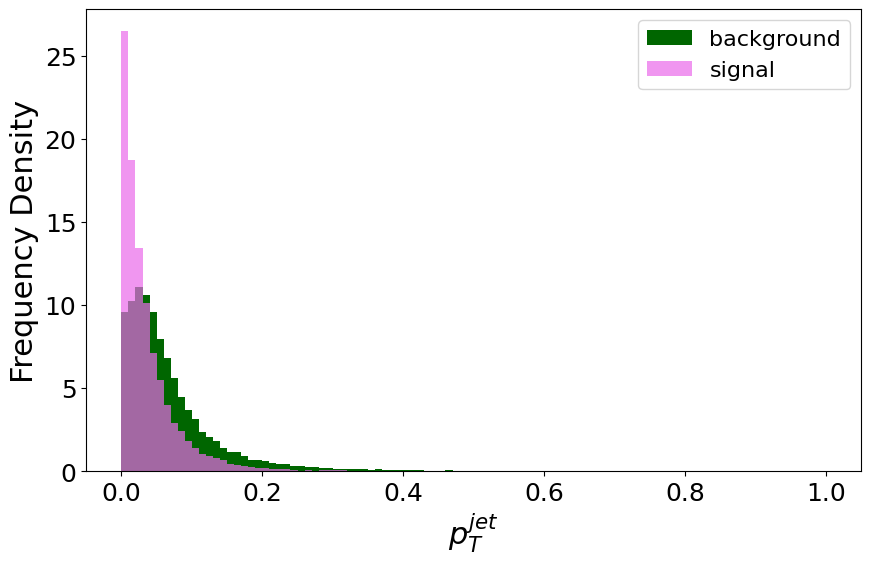

In [68]:
#First need to plot values here to check if they're okay at this point before processing:
dftest= pd.read_hdf('dataframe/raw/ttbar/FCChh_tt012j.h5') #importing the data
print(dftest)

pt_jet_norm_sig = []
pt_jet_norm_bkg = []
for i in range(len(normalized_df1_complete)):
    if normalized_df1_complete['pTj1'].iloc[i] > -80:
        pt_jet_norm_sig.append(normalized_df1_complete['pTj1'].iloc[i])

for i in range(len(normalized_df2_complete)):
    if normalized_df2_complete['pTj1'].iloc[i] > -80:
        pt_jet_norm_bkg.append(normalized_df2_complete['pTj1'].iloc[i])

print(len(pt_jet_norm_sig))
print(len(pt_jet_norm_bkg))

LEGEND_SIZE = 16
SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.figure(figsize=(10, 6))

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=LEGEND_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)

#a=ttb_tau_pt #a uniform distribution
b=pt_jet_norm_bkg #a normal distribution
c=pt_jet_norm_sig

bins=np.histogram(np.hstack((b,c)), bins=50*2)[1] #get the bin edges
#plt.hist(a, bins,color='#93f393',alpha = 1,label= r'$t \bar{t}$',density = True)
plt.hist(b, bins,color='#006600',alpha = 1,label='background',density = True)
plt.hist(c, bins,color='#ea6aea',alpha = 0.7,label='signal',density = True)
#plt.title('Distribution of invariant mass of b-jets')
plt.xlabel(r'$p_T^{jet}$')
plt.ylabel('Frequency Density')
plt.legend()
#plt.xlim(0,0.1)
#plt.savefig('/user/svalentine/GNN_summer/Norm_check/distribution/jet_pT_notcut.png')
plt.show()

In [13]:
from sparticles import EventsDataset

import matplotlib.pyplot as plt

from sparticles.transforms import MakeHomogeneous
make_homogeneous_trans = MakeHomogeneous()

from sparticles import plot_event_2d

import torch

import pandas as pd

from torch_geometric.data import InMemoryDataset, download_url

In [79]:
#testing if it will process:
sig_no = 21800
FCChh_tt012j = 21800
ttb_no = 0

import os
processed_file = f"dataframe/processed/events_signal_{sig_no}_singletop_{FCChh_tt012j}_ttbar_{ttb_no}.pt"

def remove_processed(filename):
    try:
        os.remove(filename)
    except OSError as e: 
        if e.errno != errno.ENOENT: 
            raise

remove_processed(processed_file)

cols = USEFUL_COLS = [
            # tau
            'pTt1',
            'etat1',
            'phit1',
            'nan',
            'nan',
            'nan',
            'nan',
            'nan',
            'nan',
            'nan',
            'nan',
            'nan',
            # # lepton
            'pTl1',
            'etal1',
            'phil1',
            'nan',
            'nan',
            'nan',
            'nan',
            'nan',
            'nan',
            'nan',
            'nan',
            'nan',
             # b1 
            'pTb1',
            'etab1',
            'phib1',
            'nan',
            'nan',
            'nan',
            'nan',
            'nan',
            'nan',
            'nan',
            'nan',
            'nan',
            #b2
            'pTb2',
            'etab2',
            'phib2',
            'nan',
            'nan',
            'nan',
            'nan',
            'nan',
            'nan',
            'nan',
            'nan',
            'nan',
            # energy
            'ETMiss',
            'nan',
            'ETMissPhi',
            'nan',
            'nan',
            'nan',
            'nan',
            'nan',
            'nan',
            'nan',
            'nan',
            'nan',
            # jet 3
            'pTj1',
            'etaj1',
            'phij1',
            'nan',
            'nan',
            'nan',
            'nan',
            'nan',
            'nan',
            'nan',
            'nan',
            'nan',
           # complex features
            'nan',
            'nan',
            'nan',
            'nan',
            'nan',
            'nan',
            'nan',
            'nan',
            'nan',
            'nan',
            'nan',
            'nan',
            # 'm_bb',
            # 'dR',
            # 'm_tt',
            # 'dR_tt',
            # 'Cmet',
            # 'dpT',
            # 'mTW',
            # 'mhh',
            # 'dPhi_hh',
]

graphs = EventsDataset(
    root='dataframe', #notice how root is different to get new h5 file with complex features included.
    url='https://cernbox.cern.ch/s/8Oh5dfiB9K3qHnl/download',
    delete_raw_archive=False,
    add_edge_index=True,
    event_subsets={'signal': sig_no, 'singletop': FCChh_tt012j, 'ttbar': ttb_no},
    transform=MakeHomogeneous(),
    download_type=2,
    signal_filename='FCChh_lephad.h5',
    useful_cols= cols,
    normalize=True
) # Specify the signal filename here

Processing...
Processing events in dataframe/raw/signal/FCChh_lephad.h5: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 21800/21800 [00:03<00:00, 6659.26it/s]
Processing events in dataframe/raw/signal/FCChh_lephad.h5: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 21800/21800 [00:02<00:00, 7883.86it/s]
Processing events in dataframe/raw/singletop/FCChh_lephad.h5: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 21800/21800 [00:03<00:00, 6752.31it/s]
Processing events in dataframe/raw/signal/FCChh_lephad.h5: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 21800/21800 [00:02<00:00, 8018.85it/s]
Processing events in dataframe/raw/singletop/FCChh_lephad.h5: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 

In [96]:
#dataset = graphs
print(dataset[0].x.shape)
print(dataset[0])
print(dataset[0].x)


six = []
seven = []
eight = []
for i in range(len(dataset)):
    if dataset[i].x.shape == (6,10):
        six.append(dataset[i])

    elif dataset[i].x.shape == (7,10):
        seven.append(dataset[i])

    elif dataset[i].x.shape == (8,10):
        eight.append(dataset[i])

print('six:', len(six))
print('seven:', len(seven))
print('eight:', len(eight))

torch.Size([6, 3])
Data(x=[6, 3], edge_index=[2, 30], y=[1], event_id='signal_152111')
tensor([[ 55.2565,  -1.6378,   1.4826],
        [ 20.3155,  -2.5640,   0.3211],
        [105.8601,  -2.4934,  -1.3454],
        [ 80.9242,  -2.3500,  -2.7267],
        [106.6321,      nan,   0.9098],
        [ 29.8768,  -1.9078,   2.8322]], dtype=torch.float64)
six: 0
seven: 0
eight: 0


In [97]:
tau = 0
l1 = 1
b1 = 2
b2 = 3
energy = 4
jet = 6
cmplx = 5

pT = 0
eta = 2
phi = 4

dataset = graphs

def obj_ft(obj,ft):

    sig_obj_ft = []
    bkg_obj_ft = []

    for i in range(len(dataset)):
        print(dataset[i].x)
        print(obj)

        if dataset[i].x.shape == (1,10) and obj == 6: #makes it so that final object (jet) is skipped for graphs without an extra jet.
            continue
        
        elif dataset[i].y.item() == 1: #and dataset[i].x.shape == (6,3):  
            sig_obj_ft.append(dataset[i].x[obj,ft].item())

        elif dataset[i].y.item() == 0: # and dataset[i].x.shape == (6,3):
            bkg_obj_ft.append(dataset[i].x[obj,ft].item())
    
    return sig_obj_ft, bkg_obj_ft

In [93]:
#checking normalised distributions:
# for i in range(len(dataset)):

#         if dataset[i].x.shape == (6,3) and obj == 5: #makes it so that final object (jet) is skipped for graphs without an extra jet.
#             continue
        
#         elif dataset[i].y.item() == 1 and dataset[i].x.shape == (6,3): #and dataset[i].x.shape == (6,3):  
#             sig_obj_ft.append(dataset[i].x[obj,ft].item())

#         elif dataset[i].y.item() == 0 and dataset[i].x.shape == (6,3): # and dataset[i].x.shape == (6,3):
#             bkg_obj_ft.append(dataset[i].x[obj,ft].item())
    
#     return sig_obj_ft, bkg_obj_ft

print(jet)

sig_jet_pT, bkg_jet_pT = obj_ft(jet, pT)

# sig_jetreal_pT = []
# for i in range(len(sig_jet_pT)):
#     if sig_jet_pT[i] > 0.1:
#         sig_jetreal_pT.append(sig_jet_pT[i])

# bkg_jetreal_pT = []
# for i in range(len(bkg_jet_pT)):
#     if bkg_jet_pT[i] > 0.1:
#         bkg_jetreal_pT.append(bkg_jet_pT[i])

LEGEND_SIZE = 16
SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.figure(figsize=(10, 6))

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=LEGEND_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)

#a=ttb_tau_pt #a uniform distribution
b=bkg_jet_pT #a normal distribution
c=sig_jet_pT

bins=np.histogram(np.hstack((b,c)), bins=50*2)[1] #get the bin edges
#plt.hist(a, bins,color='#93f393',alpha = 1,label= r'$t \bar{t}$',density = True)
plt.hist(b, bins,color='#006600',alpha = 1,label='background',density = True)
plt.hist(c, bins,color='#ea6aea',alpha = 0.7,label='signal',density = True)
#plt.title('Distribution of invariant mass of b-jets')
plt.xlabel(r'normalised $p_T^{jet}$')
#plt.xlim(0.3,0.7)
plt.ylabel('Frequency Density')
plt.legend()
#plt.savefig('/user/svalentine/GNN_summer/Norm_check/distribution/jet_pT_fixed.png')
plt.show()

6
tensor([[0.1055, 0.0000, 0.6492, 0.0000, 0.5652, 0.0000, 0.0000, 1.0000, 0.0000,
         1.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 1.0000,
         0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0951, 0.0000, 0.6780,
         0.0000],
        [0.3872, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000,
         1.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 1.0000,
         0.0000, 1.0000, 0.0209, 0.0000, 0.7330, 0.0000, 0.9458, 0.0000, 0.0000,
         1.0000]])
6


IndexError: index 6 is out of bounds for dimension 0 with size 2

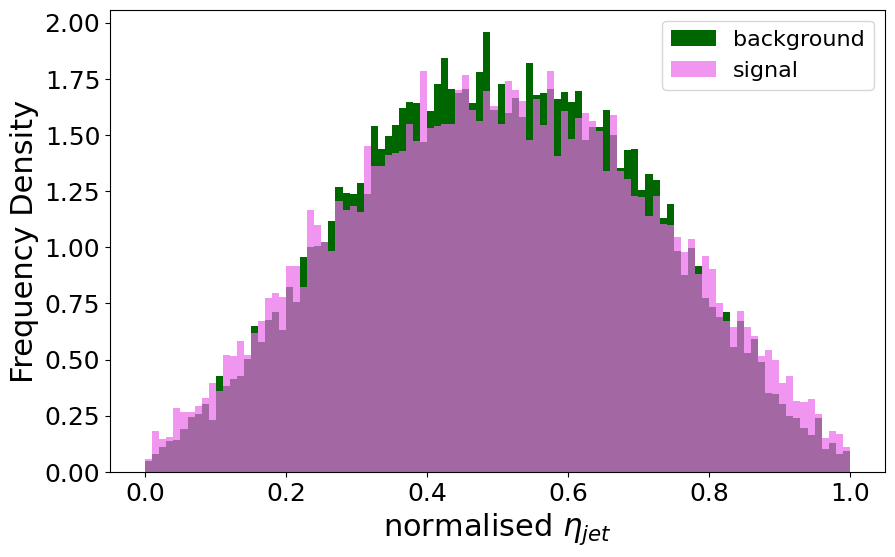

In [23]:
#checking normalised distributions:
# for i in range(len(dataset)):

#         if dataset[i].x.shape == (6,3) and obj == 5: #makes it so that final object (jet) is skipped for graphs without an extra jet.
#             continue
        
#         elif dataset[i].y.item() == 1 and dataset[i].x.shape == (6,3): #and dataset[i].x.shape == (6,3):  
#             sig_obj_ft.append(dataset[i].x[obj,ft].item())

#         elif dataset[i].y.item() == 0 and dataset[i].x.shape == (6,3): # and dataset[i].x.shape == (6,3):
#             bkg_obj_ft.append(dataset[i].x[obj,ft].item())
    
#     return sig_obj_ft, bkg_obj_ft


sig_jet_eta, bkg_jet_eta = obj_ft(jet,eta)

# sig_jetreal_pT = []
# for i in range(len(sig_jet_pT)):
#     if sig_jet_pT[i] > 0.1:
#         sig_jetreal_pT.append(sig_jet_pT[i])

# bkg_jetreal_pT = []
# for i in range(len(bkg_jet_pT)):
#     if bkg_jet_pT[i] > 0.1:
#         bkg_jetreal_pT.append(bkg_jet_pT[i])

LEGEND_SIZE = 16
SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.figure(figsize=(10, 6))

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=LEGEND_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)

#a=ttb_tau_pt #a uniform distribution
b=bkg_jet_eta #a normal distribution
c=sig_jet_eta

bins=np.histogram(np.hstack((b,c)), bins=50*2)[1] #get the bin edges
#plt.hist(a, bins,color='#93f393',alpha = 1,label= r'$t \bar{t}$',density = True)
plt.hist(b, bins,color='#006600',alpha = 1,label='background',density = True)
plt.hist(c, bins,color='#ea6aea',alpha = 0.7,label='signal',density = True)
#plt.title('Distribution of invariant mass of b-jets')
plt.xlabel(r'normalised $\eta_{jet}$')
#plt.xlim(0.3,0.7)
plt.ylabel('Frequency Density')
plt.legend()
#plt.savefig('/user/svalentine/GNN_summer/Norm_check/distribution/jet_pT_fixed.png')
plt.show()